In [1]:
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt
import numpy
import iris.coord_categorisation

In [2]:
%matplotlib inline

In [3]:
infile = '/g/data/ua6/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/mon/ocean/r1i1p1/msftmyz/latest/msftmyz_Omon_CSIRO-Mk3-6-0_historical_r1i1p1_185001-200512.nc'

In [4]:
cube = iris.load_cube(infile, 'ocean_meridional_overturning_mass_streamfunction')

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [5]:
print(cube)

ocean_meridional_overturning_mass_streamfunction / (kg s-1) (time: 1872; -- : 3; depth: 31; latitude: 189)
     Dimension coordinates:
          time                                                   x          -         -             -
          depth                                                  -          -         x             -
          latitude                                               -          -         -             x
     Attributes:
          Conventions: CF-1.4
          branch_time: 29200.0
          cmor_version: 2.6.0
          comment: Generated by script CMIP5_Mk36_msftmyz.ncl using CMIP5 parameters as i...
          contact: Project leaders: Stephen Jeffrey (Stephen.Jeffrey@qld.gov.au) & Leon Rotstayn...
          creation_date: 2011-07-27T03:00:00Z
          experiment: historical
          experiment_id: historical
          forcing: Ant,Nat (all forcings)
          frequency: mon
          history: Derived (not model generated) quantity.
          initial

In [6]:
dim_coord_names = [coord.name() for coord in cube.dim_coords]
print(dim_coord_names)

['time', 'depth', 'latitude']


In [7]:
aux_coord_names = [coord.name() for coord in cube.aux_coords]
print(aux_coord_names)

[]


In [8]:
mf_cube = cube[:, 0, : ,:]

In [9]:
mf_cube

<iris 'Cube' of ocean_meridional_overturning_mass_streamfunction / (kg s-1) (time: 1872; depth: 31; latitude: 189)>

In [10]:
mf_clim_cube = mf_cube.collapsed('time', iris.analysis.MEAN)

In [11]:
mf_clim_cube

<iris 'Cube' of ocean_meridional_overturning_mass_streamfunction / (kg s-1) (depth: 31; latitude: 189)>

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


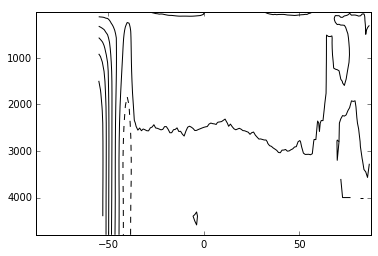

In [12]:
iplt.contour(mf_clim_cube, colors='k')
# plt.clabel(contour_plot) fmt='%.1f')
plt.show()

In [13]:
depth_constraint = iris.Constraint(depth= lambda cell: cell <= 250)
lat_constraint = iris.Constraint(latitude=lambda cell: -30.0 <= cell < 30.0)

In [14]:
tropics_cube = mf_clim_cube.extract(depth_constraint & lat_constraint)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


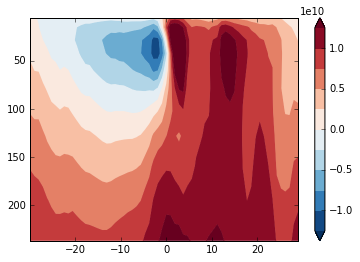

In [18]:
iplt.contourf(tropics_cube, cmap='RdBu_r',
              levels=[-1.25e+10, -1.0e+10, -7.5e+9, -5.0e+9, -2.5e+9, 0, 2.5e+9, 5.0e+9, 7.5e+9, 1.0e+10, 1.25e+10],
              extend='both')
plt.colorbar()
plt.show()

In [27]:
tropics_cube.data.max()

5.9115131e+10

In [16]:
sh_lat_constraint = iris.Constraint(latitude=lambda cell: -30.0 <= cell < 0.0)
nh_lat_constraint = iris.Constraint(latitude=lambda cell: 0.0 < cell <= 30.0)

In [19]:
sh_cube = mf_cube.extract(depth_constraint & sh_lat_constraint)
nh_cube = mf_cube.extract(depth_constraint & nh_lat_constraint)

In [18]:
sh_cube

<iris 'Cube' of ocean_meridional_overturning_mass_streamfunction / (kg s-1) (time: 1872; depth: 11; latitude: 32)>

Probably needs to be a depth and latitude weighted mean...

In [21]:
def convert_to_annual(cube, full_months=False, aggregation='mean'):
    """Convert data to annual timescale.
    Args:
      cube (iris.cube.Cube)
      full_months(bool): only include years with data for all 12 months
    """

    iris.coord_categorisation.add_year(cube, 'time')
    iris.coord_categorisation.add_month(cube, 'time')

    if aggregation == 'mean':
        aggregator = iris.analysis.MEAN
    elif aggregation == 'sum':
        aggregator = iris.analysis.SUM

    cube = cube.aggregated_by(['year'], aggregator)

    if full_months:
        cube = cube.extract(iris.Constraint(month='Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec'))
  
    cube.remove_coord('year')
    cube.remove_coord('month')

    return cube

In [22]:
sh_cube = convert_to_annual(sh_cube)
nh_cube = convert_to_annual(nh_cube)

In [25]:
sh_metric = sh_cube.collapsed(['depth', 'latitude'], iris.analysis.MEAN) # weights=grid_areas)
nh_metric = nh_cube.collapsed(['depth', 'latitude'], iris.analysis.MEAN) # weights=grid_areas)

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/cube.py:3281: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


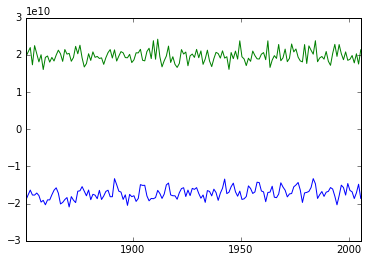

In [27]:
iplt.plot(sh_metric)
iplt.plot(nh_metric)
plt.show()

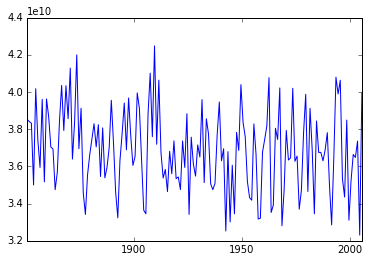

In [28]:
iplt.plot(nh_metric - sh_metric)
plt.show()